In [1]:
import numpy as np
import glob, os
import xarray as xr
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import shapely.geometry as sgeom
import matplotlib.patheffects as path_effects
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [37]:
topfile = '/global/project/projectdirs/m1867/zfeng/globe_topography/ETOPO1_Ice_g_gmt4.nc'
topfile_wrf = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask.nc'

figdir = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/'

In [4]:
dstop = xr.open_dataset(topfile)
dstop

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

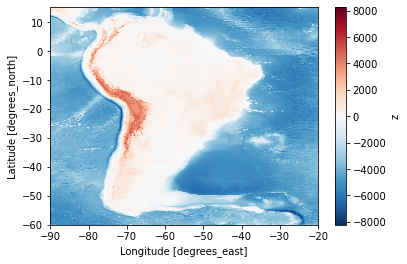

In [8]:
# Crop South America region
ter = dstop.z.sel(x=slice(-90,-20), y=slice(-60,15))
lon = dstop.x.sel(x=slice(-90,-20))
lat = dstop.y.sel(y=slice(-60,15))
landmask = ter >= 0
ter.plot()

In [7]:
dsw = xr.open_dataset(topfile_wrf)
dsw

<xarray.Dataset>
Dimensions:   (Time: 1, south_north: 2027, west_east: 1471)
Coordinates:
    XLAT      (Time, south_north, west_east) float32 ...
    XLONG     (Time, south_north, west_east) float32 ...
    XTIME     (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    HGT       (Time, south_north, west_east) float32 ...
    LAKEMASK  (Time, south_north, west_east) float32 ...
    LANDMASK  (Time, south_north, west_east) float32 ...
    LU_INDEX  (Time, south_north, west_east) float32 ...
Attributes: (12/149)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Tue Jun  8 21:44:21 2021: ncks -v XLONG,...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...

In [11]:
dswc = dsw.coarsen(west_east=2, south_north=2, boundary='trim', keep_attrs=True).mean()
dswc

<xarray.Dataset>
Dimensions:   (Time: 1, south_north: 1013, west_east: 735)
Coordinates:
    XLAT      (Time, south_north, west_east) float32 -54.5 -54.51 ... 15.37
    XLONG     (Time, south_north, west_east) float32 -98.44 -98.33 ... -34.86
    XTIME     (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    HGT       (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LAKEMASK  (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LANDMASK  (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LU_INDEX  (Time, south_north, west_east) float32 17.0 17.0 ... 17.0 17.0
Attributes: (12/149)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Tue Jun  8 21:44:21 2021: ncks -v XLONG,...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...

<ipython-input-14-23058a82f887>:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(dswc.XLONG.squeeze(), dswc.XLAT.squeeze(), dswc.HGT.squeeze(), shading='auto', vmin=0, vmax=4000, cmap='terrain')


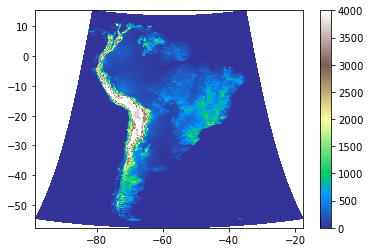

In [14]:
plt.pcolormesh(dswc.XLONG.squeeze(), dswc.XLAT.squeeze(), dswc.HGT.squeeze(), shading='auto', vmin=0, vmax=4000, cmap='terrain')
plt.colorbar()

In [41]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def compute_radius(proj, lat, lon, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = proj.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

def calc_latlon(lon1, lat1, dist, angle):
    """
    Haversine formula to calculate lat/lon locations from distance and angle.
    
    lon1:   longitude in [degree]
    lat1:   latitude in [degree]
    dist:   distance in [km]
    angle:  angle in [degree]
    """

    import math

    # Earth radius
    # R_earth = 6378.39  # at Equator [km]
    R_earth = 6374.2  # at 40 degree latitude [km]
#     R_earth = 6356.91  # at the pole [km]

    # Conver degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(angle)

    lat2 = math.asin(math.sin(lat1) * math.cos(dist/R_earth) +
                     math.cos(lat1) * math.sin(dist/R_earth) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(dist/R_earth) * math.cos(lat1),
                             math.cos(dist/R_earth) - math.sin(lat1) * math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lon2, lat2

In [ ]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -91
lonmax = -25
latmin = -58
latmax = 15.1
map_extend = [lonmin, lonmax, latmin, latmax]

lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,10))
levelshgt = [1000,2000]

fig = plt.figure(figsize=[10,7], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
ax.add_feature(ocean, edgecolor='k', facecolor='none')
ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=2)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,4000.1,50)
cbticks = np.arange(0,4000.1,500)
cmap = plt.get_cmap('terrain')
# cmap = truncate_colormap(cmap, 0.22, 1)
# Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cf1 = ax.pcolormesh(dsw.XLONG.squeeze(), dsw.XLAT.squeeze(), dsw.HGT.squeeze(), shading='auto', 
                    norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
cb = plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('SAAG WRF Domain', loc='center')
ax.text(-60, -55, 'GPM Domain', color='magenta', fontsize=15, zorder=10)

# GPM subset domain
gpm_lonmin, gpm_lonmax = -82, -34
gpm_latmin, gpm_latmax = -56, 13
gpm_domain = sgeom.box(minx=gpm_lonmin, maxx=gpm_lonmax, miny=gpm_latmin, maxy=gpm_latmax)
ax.add_geometries([gpm_domain], proj, facecolor='none', edgecolor='magenta', lw=2, zorder=5)

figname = f'{figdir}SAAG_wrf_domain_map.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [36]:
figname

'/global/project/projectdirs/m1867/zfeng/SAAG/wrfSAAG_wrf_domain_map.png'

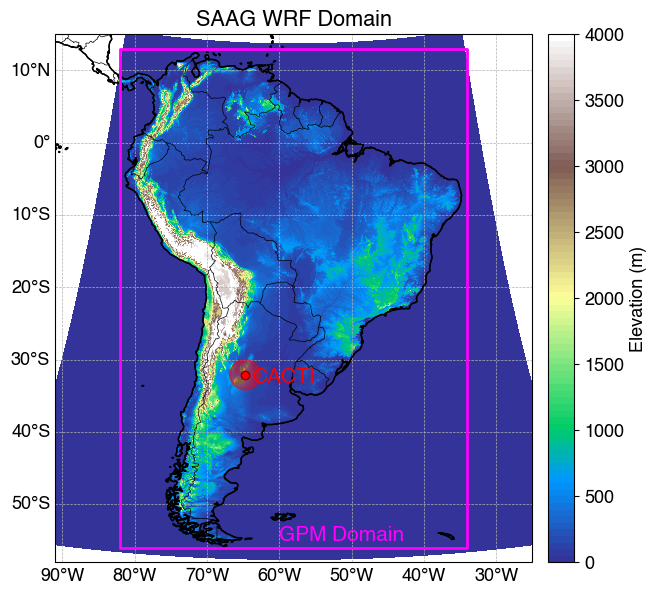

In [51]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -91
lonmax = -25
latmin = -58
latmax = 15.1
map_extend = [lonmin, lonmax, latmin, latmax]

lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,10))
levelshgt = [1000,2000]

fig = plt.figure(figsize=[10,7], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
ax.add_feature(ocean, edgecolor='k', facecolor='none')
ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=2)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,4000.1,50)
cbticks = np.arange(0,4000.1,500)
cmap = plt.get_cmap('terrain')
# cmap = truncate_colormap(cmap, 0.1, 1)
# Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cf1 = ax.pcolormesh(dsw.XLONG.squeeze(), dsw.XLAT.squeeze(), dsw.HGT.squeeze(), shading='auto', 
                    norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
cb = plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('SAAG WRF Domain', loc='center')
ax.text(-60, -55, 'GPM Domain', color='magenta', fontsize=15, zorder=10)

# AMF site
radar_lon = -64.75
radar_lat = -32.1
ax.plot(radar_lon, radar_lat, color='red', marker='o', markersize=6)
ax.plot(radar_lon, radar_lat, color='k', marker='o', markersize=6, fillstyle='none')
ax.text(radar_lon+1, radar_lat-1, 'CACTI', color='red', fontsize=15, zorder=10)

# Compute the required radius in projection native coordinates:
r_proj = compute_radius(proj, radar_lat, radar_lon, 0.1)
r_proj = 2.1
# Draw a patch circle
ax.add_patch(mpatches.Circle(xy=[radar_lon, radar_lat], radius=r_proj, color='r', alpha=0.5, transform=proj, zorder=6))

# GPM subset domain
gpm_lonmin, gpm_lonmax = -82, -34
gpm_latmin, gpm_latmax = -56, 13
gpm_domain = sgeom.box(minx=gpm_lonmin, maxx=gpm_lonmax, miny=gpm_latmin, maxy=gpm_latmax)
ax.add_geometries([gpm_domain], proj, facecolor='none', edgecolor='magenta', lw=2, zorder=5)

figname = f'{figdir}SAAG_wrf_domain_map_CACTI.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [53]:
print(-82 % 360)
print(-34 % 360)

278
326
